$\pagebreak$

## User's Guide
This document is the data product, interactive dashboard, and documentation. However, you may be viewing this document in one of three ways: as a static pdf (`.pdf`); as a static Jupyter notebook (`.ipynb`, perhaps on GitHub.com); or as an interactive Jupyter Notebook, perhaps via mybinder.org. This document will not interact with you unless you are viewing it interactively. The static forms of this document are complete and accurate records of the source code for the data product and display its actual behavior, with the exception of the interactive query, which cannot be displayed or interacted with statically.

To start viewing the data product interactively:

1. Click on [this link](https://mybinder.org/v2/gh/FractalMachinist/WGU-C968/HEAD?labpath=In%20The%20Loupe%20Phase%201%20Report.ipynb).
2. Wait for a few progress bars, until you see this user's guide again.
    - That view of the data product is now interactive.
3. Launch the data product.
    - At the top of an interactive view, a row of symbols should include a floppy disk, plus sign, clipboard, and play/pause buttons. Clicking the play button once will begin executing the data product and dashboard.
4. Open the interactive Table of Contents.
    - On the leftmost edge of an interactive view, in a column of symbols including a file folder and a puzzle piece, click on a bulleted list to display a navigable table of contents.


To navigate through the document:

1. Start with the summary.
    - For WGU Evaluators, I then recommend navigating to the [WGU Evaluator's Guide](#WGU-Evaluators-Guide). It's structure will guide you through evaluation. To access it, scroll to the end of this notebook, then back about 1 page.
    - For FBay Evaluators, the most important results are linked in the Evaluation section of the summary.
2. View the [interactive model](#Interactive-Model).
    - View the data product interactively (see above).
    - Launch the data product (see above).
        - It may be some time before every part of the data product is prepared.
    - Navigate to the interactive model (link above).
    - If necessary, wait until there are several horizontal sliders and a small block of text displayed.
    - Click and drag the selection circle on the slider, or click on the field to the right of a slider, to input a feature for a diamond you might want to know the price of.
    - The updated price prediction will appear immediately.
        - The model assigns identical prices to similar diamonds, and some features (listed last) make no difference most of the time.
        - If the interactivity seems to have stopped, try changing the `carat` slider a significant amount. The model is not frozen, it's just predicting the same result.


This notebook has long sections of code which only contribute to functionality, and not necesarily to efficient summarization. Every relevant discussion, conclusion, and supporting detail will appear stylistically like this, rather than in highlighted source code, like this:

```python
# Check if the text you're reading is source code.
if some_text.style() is this.style():
    some_text.is_code = True;
    some_text.is_discussion = False;
```

#### Configuring logging

In [1]:
# Suggested via https://stackoverflow.com/a/47796399
# Tee logging into a file
import sys, logging
my_stderr = sys.stderr = open("error.txt", "a+") # redirect stderr to file
get_ipython().log.handlers[0].stream = my_stderr # Log errors to new stderr (errors are annotated for color)
get_ipython().log.setLevel(logging.INFO)         # Configure logging of errors   

In [2]:
enable_visualizations = True  # Computing visualizations takes about a minute total.
run_performance_tests = False # Performance tests take over 30m. If False, use prior performance data instead.

$\pagebreak$

# Summary  
## Project Purpose  
This phase of the project focused on determining if a model can be produced which predicts diamond prices based on features, meeting accuracy and performance KPIs set by FBay's customers and stakeholders.

## Dataset  
([Data](#Data-to-Information))  
The model was trained on ~54,000 diamonds sold through FBay’s gemstone marketplace. This data was collected into a CSV file and hosted at [kaggle.com](https://www.kaggle.com/datasets/nancyalaswad90/diamonds-prices). _Evaluator: This data did not originate from FBay, the fictional company. This data originated from the linked kaggle.com dataset._

## Model Design  
([Model](#Fitting-the-Model))  
The model selected was a Decision Tree, based on its ease of training and efficiency on commodity hardware. The model was trained on an 80% split of the data, and its accuracy was validated on the remaining 20%. 

## Evaluation  
([Evaluation](#Model-Evaluation))  
([Hypothesis Verification](#Hypothesis-Verification))  
([Conclusions and Recommendations](#Conclusions-and-Recommendations))  

The model’s accuracy on validation data was 96.4%, exceeding the project’s KPI of 95%. The model was also evaluated for its throughput and latency, exceeding KPIs.

## Model Demonstration  
([Demonstration](#Interactive-Price-Prediction))  
This notebook features an interactive querying tool. See [User's Guide](#Users-Guide) for how to execute this notebook interactively.

# Data to Information

## Dataset Selection

The model was trained from data in a CSV file hosted at [kaggle.com](https://www.kaggle.com/datasets/nancyalaswad90/diamonds-prices). These data include cut, color, clarity, carat, depth, table (the size of the largest top facet), length in x, y, and z, and sale price for ~54,000 diamonds.

In [3]:
CSV_PATH="./DiamondsPrices2022.csv"

In [4]:
import pandas as pd, seaborn as sns, numpy as np, matplotlib.pyplot as plt, matplotlib.gridspec as gridspec
from scipy import stats

In [5]:
diamonds_dirty = pd.read_csv(CSV_PATH, index_col=0)
diamonds_dirty.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## Data Pipeline

### Cleaning Steps

The data were largely clean from the source, but some diamonds (20 of them) were listed as having sizes of zero mm. This was considered unreasonable, and those diamonds were removed from the dataset.

In [6]:
# Null values
diamonds_dirty[diamonds_dirty.isnull().any(axis=1)]

,carat,cut,color,clarity,depth,table,price,x,y,z


In [7]:
# Zeros
diamonds_dirty[diamonds_dirty.select_dtypes(include=['number']).eq(0).any(axis=1)]

,carat,cut,color,clarity,depth,table,price,x,y,z
2208,1.00,Premium,G,SI2,59.1,59.0,3142,6.55,6.48,0.0
2315,1.01,Premium,H,I1,58.1,59.0,3167,6.66,6.60,0.0
4792,1.10,Premium,G,SI2,63.0,59.0,3696,6.50,6.47,0.0
5472,1.01,Premium,F,SI2,59.2,58.0,3837,6.50,6.47,0.0
10168,1.50,Good,G,I1,64.0,61.0,4731,7.15,7.04,0.0
11183,1.07,Ideal,F,SI2,61.6,56.0,4954,0.00,6.62,0.0
11964,1.00,Very Good,H,VS2,63.3,53.0,5139,0.00,0.00,0.0
13602,1.15,Ideal,G,VS2,59.2,56.0,5564,6.88,6.83,0.0
15952,1.14,Fair,G,VS1,57.5,67.0,6381,0.00,0.00,0.0
24395,2.18,Premium,H,SI2,59.4,61.0,12631,8.49,8.45,0.0


In [8]:
# Empty Strings
diamonds_dirty[diamonds_dirty.eq("").any(axis=1)]

,carat,cut,color,clarity,depth,table,price,x,y,z


In [9]:
diamonds_dirty = diamonds_dirty[~diamonds_dirty.select_dtypes(include=['number']).eq(0).any(axis=1)]
diamonds_dirty = diamonds_dirty[(np.abs(stats.zscore(diamonds_dirty.select_dtypes(include=['number']))) < 10).all(axis=1)]

diamonds_clean = diamonds_dirty

### Qualitative Data
This dataset required very minimal feature engineering, limited to assigning numeric values to the ordinal categories described below.

#### What data are qualitative?

In [10]:
_ = diamonds_clean.select_dtypes(include='object').apply(lambda col: print(f"{col.name}\t: {col.unique()}"))

cut	: ['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
color	: ['E' 'I' 'J' 'H' 'F' 'G' 'D']
clarity	: ['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']


#### Exogenous definitions of Cut, Color, and Clarity

Cut diverges from the [GIA Diamond Cut Scale](https://4cs.gia.edu/en-us/diamond-cut/) in terminology. It is a 5-step ordinal scale.
  
Color follows the [GIA Diamond Color Scale](https://4cs.gia.edu/en-us/diamond-color/), which is ordinal from Z to D (better scores are earlier letters), the last 7 (J-D) of which are present.
  
Clarity follows the [GIA Diamond Clarity Scale](https://4cs.gia.edu/en-us/diamond-clarity/), which is ordinal across 11 values, 8 of which are present.

#### Embedding ordinality information

In [11]:
ordinal_scales = {
    "cut":      ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'],
    "color":    ['D', 'E', 'F', 'G', 'H', 'I', 'J'][::-1], # Reversed because better scores are earlier letters
    "clarity":  ["I1", "SI1", "SI2", "VS1", "VS2", "VVS1", "VVS2", "IF"]
}

In [12]:
for column_name, scale in ordinal_scales.items():
    col = diamonds_clean[column_name].astype("category").cat.set_categories(scale, ordered=True)
    diamonds_clean[column_name] = col
    diamonds_clean[column_name + "_num"] = col.cat.codes

diamonds_information = diamonds_clean.copy()

diamonds_information.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53913 entries, 1 to 53943
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   carat        53913 non-null  float64 
 1   cut          53913 non-null  category
 2   color        53913 non-null  category
 3   clarity      53913 non-null  category
 4   depth        53913 non-null  float64 
 5   table        53913 non-null  float64 
 6   price        53913 non-null  int64   
 7   x            53913 non-null  float64 
 8   y            53913 non-null  float64 
 9   z            53913 non-null  float64 
 10  cut_num      53913 non-null  int8    
 11  color_num    53913 non-null  int8    
 12  clarity_num  53913 non-null  int8    
dtypes: category(3), float64(6), int64(1), int8(3)
memory usage: 3.6 MB


$\pagebreak$

## Univariate Analysis

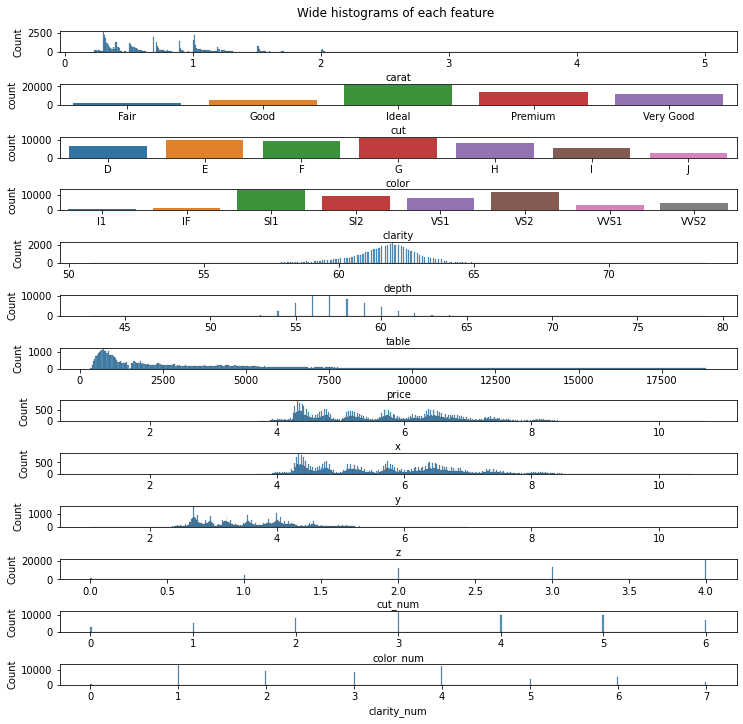

In [13]:
# Visualizing each feature
if enable_visualizations:
    univariate_analysis_figure, UA_axes = plt.subplots(len(diamonds_information.columns), figsize=(10, 10))
    univariate_analysis_figure.suptitle("Wide histograms of each feature")
    univariate_analysis_figure.tight_layout()
    xyz_axes = []
    first_xyz_axis = None
    for axis, column_key in zip(UA_axes, diamonds_information.columns):
        data = diamonds_information[column_key]
        if data.dtype == 'category':
            sns.countplot(data=diamonds_information, x=column_key, ax=axis, order=sorted(data.unique()))
        else:
            sns.histplot(data=diamonds_information, x=column_key, ax=axis, bins=500)
            if column_key in list("xyz"):
                xyz_axes.append(axis)

    xyz_axes[0].get_shared_x_axes().join(xyz_axes[0], *xyz_axes)
    for xyz_ax in xyz_axes:
        xyz_ax.autoscale()

This visualization provides an effective overview of the values each feature takes on. Because this visualization enabled easy identification of binning and resolution limits in the data, it was instrumental in informing and improving the quality of other visualizations. Specifically, it started a line of investigation which allowed manual construction of histogram bins which best fit the resolution of each feature.

### What obvious artifacts are there?
- Precision
    - Table
    - Depth
- Rounding
    - Carat
    - X / Y / Z
- Other
    - Price

#### Artifact Investigations
One of the application testing phases I completed was comparing the type, resolution, and range of values before and after the data pipeline. These visualizations were created to support that integration testing phase. Specifically, they helped demonstrate that rounding artifacts in the product end of the pipeline were identical to the numerical precision in the CSV datafile.

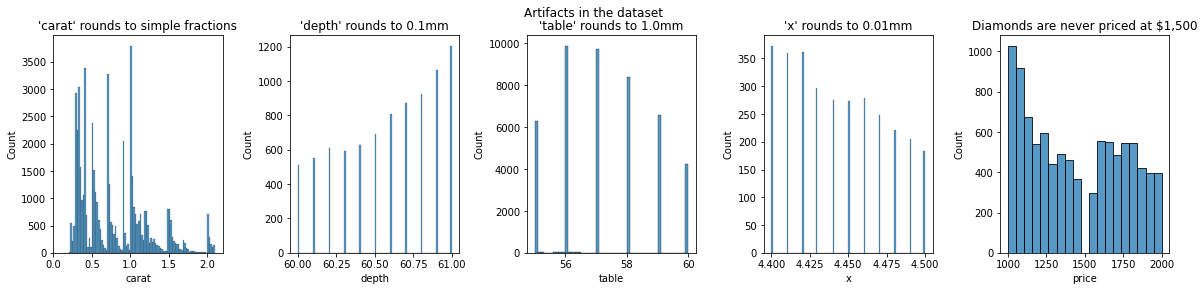

In [14]:
if enable_visualizations:
    artifacts_fig, artifacts_ax = plt.subplots(1, 5, squeeze=False, figsize=(20,4), gridspec_kw={"wspace":0.4})
    artifacts_fig.tight_layout(rect=[0, 0.03, 1, 0.7])
    artifacts_fig.suptitle("Artifacts in the dataset")
    sns.histplot(data=diamonds_information, x="carat", binrange=[0.1, 2.1], bins=100,   ax=artifacts_ax[0, 0]).set(title="'carat' rounds to simple fractions")
    sns.histplot(data=diamonds_information, x="depth", binrange=[60, 61],   bins=100,   ax=artifacts_ax[0, 1]).set(title="'depth' rounds to 0.1mm")
    sns.histplot(data=diamonds_information, x="table", binrange=[55, 60],   bins=50,    ax=artifacts_ax[0, 2]).set(title="'table' rounds to 1.0mm")
    sns.histplot(data=diamonds_information, x="x",     binrange=[4.4, 4.5], bins=100,   ax=artifacts_ax[0, 3]).set(title="'x' rounds to 0.01mm")
    sns.histplot(data=diamonds_information, x="price", binrange=[1000, 2000],           ax=artifacts_ax[0, 4]).set(title="Diamonds are never priced at $1,500")

In [15]:
min_resolution = {"cut_num": 1, "color_num": 1, "clarity_num": 1, "table": 1, "depth": 0.1, "x": 0.01, "y":0.01, "z":0.01}
optimal_bins   = {"cut_num": 1, "color_num": 1, "clarity_num": 1, "table": 1, "depth": 0.1}

## Application Testing - Data Pipeline
This application and report went through two main stages of testing, the first of which related to the data pipeline. The data pipeline's integration testing revolved around the ability to make accuracte graphs of the data, and those graphs were then used to further evaluate the robustness of the data pipeline. The final visual product of this testing stage can be found in [Displaying Bivariate Distributions](#Displaying-Bivariate-Distributions).  
  
Due to the cleanliness of the data source and the simplicity of the data engineering involved, the integration testing of the data pipeline was straightforward and uncomplicated.  

  
The second phase of testing is discussed in [Application Testing - Report Communication and Clarity](Application-Testing---Report-Communication-and-Clarity).

# Information to Knowledge

In [16]:
diamonds_k = diamonds_information.copy() # diamonds_knowledge

In [17]:
diamonds_k_numeric = diamonds_k.select_dtypes(include='number')

## Feature Correlations with Price

In [18]:
correlation_with_price = np.abs(diamonds_k.corrwith(diamonds_k.price)).sort_values()
print(correlation_with_price)

depth          0.010294
cut_num        0.053473
clarity_num    0.104827
table          0.127028
color_num      0.172408
z              0.882165
x              0.887217
y              0.888812
carat          0.921595
price          1.000000
dtype: float64


## Visualizing Bivariate Distributions

#### Constructing Bivariate Visualization Tools

In [19]:
import matplotlib.patches as patches
import matplotlib.collections

In [20]:
# Configure the shared color for price
norm = plt.Normalize(diamonds_k_numeric["price"].min(), diamonds_k_numeric["price"].max())
cmap = sns.color_palette("flare_r", as_cmap=True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

In [21]:
def get_axis_size_px(ax):
    fig = ax.get_figure()
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width_inches, height_inches = bbox.width, bbox.height
    return width_inches*fig.dpi, height_inches*fig.dpi

In [22]:
def fit_bins(sequence, bins=None, max_bins=None, stagger=True):
    name = sequence.name

    if name not in optimal_bins:
        bin_edges = np.histogram_bin_edges(sequence, bins="auto" if bins is None else bins)
        bin_size = bin_edges[1]-bin_edges[0]

        if (bins is not None or name not in min_resolution) and max_bins is None:
            return bin_size, bin_edges
        elif name in min_resolution:
            # We can improve the suggested bins by
            # moving size to the nearest multiple of resolution,
            # then picking new edges.
            resolution = min_resolution[name]
            bin_size = round(bin_size/resolution)*resolution
    else:
        bin_size = optimal_bins[name]
    
    seqmin = sequence.min()
    seqmax = sequence.max()

    if max_bins is not None:
        seqrange = seqmax - seqmin
        nbins = (seqrange / bin_size) + (1 if stagger else 0)

        if nbins > max_bins:
            nbins = max_bins
            bin_size = seqrange / max_bins

    if stagger:
        return bin_size, np.arange(seqmin-bin_size*0.5, seqmax+bin_size*1.5, bin_size)
    else:
        return bin_size, np.arange(seqmin, seqmax+bin_size, bin_size)

In [23]:
def potentially_categoric_histplot(*args, **kws):
    x = kws['x']
    y = kws['y']
    xname = x.name
    yname = y.name
    x_is_num = xname[-4:] == "_num"
    y_is_num = yname[-4:] == "_num"
    bins = kws.pop("bins", None)

    [xbin_size, xb], [ybin_size, yb] = [fit_bins(x, bins=bins), fit_bins(y, bins=bins)]
    sns.histplot(*args, bins=[xb, yb], **kws)

    # Secondary plot for density of x alone
    ax = kws.pop("ax")
    ax2 = ax.twinx()
    
    p2_kws = {k:kws[k] for k in kws if k != "y"}
    p2_kws["ax"] = ax2
    p2_kws["alpha"] = 0.5

    if kws['x'].name in optimal_bins:
        sns.histplot(*args, **p2_kws, bins=xb, stat="density", element="step", fill=False)
    else:
        sns.kdeplot(*args, **p2_kws, common_norm=True)
    
    ax2.yaxis.set_visible(False)

potentially_categoric_histplot.__module__ = "seaborn"

In [24]:
def sized_heatmap(xy_group_ref, ax, bin_size, sm):
    blocks = []
    xy_group = xy_group_ref.copy()

    # # Compute the naive size of the block in data coordinates
    block_size_v1 = bin_size[None, :]*xy_group["count_normed_sqrt"].to_numpy()[:, None]
    # # Transform the data coordinates into the number of pixels the block would occupy
    block_pixels_v1=ax.transData.transform(block_size_v1) - [ax.transData.transform([0, 0])]
    # # Get how much less than a pixel each axis is
    fractional_pixels_v1 = np.minimum(block_pixels_v1, 1)

    # # If a block is <1px in one axis, shrink the other axis and grow that axis by that axis's fraction.
    
    aspect_transform = fractional_pixels_v1[:, ::-1] / fractional_pixels_v1 # The product of aspect_transform should be 1

    block_size_v2 = block_size_v1 * aspect_transform # Scale up the small axis and down the large axis to preserve total size
    block_pixels_v2=block_pixels_v1*aspect_transform # Short-compute the new pixels by the same transformation
    fractional_pixels_v2 = np.minimum(block_pixels_v2, 1) # New values for how much less than a pixel each axis is

    # # If the block is <1px even after shifting the aspect ratio, pull the size up to 1px and we'll give it an alpha
    block_size = block_size_v2 / fractional_pixels_v2
    alpha=np.prod(fractional_pixels_v2, axis=1)
    color = sm.to_rgba(xy_group["price"])

    # Build a rectangle for each entry, zipped together
    for index, block_size, alpha, color in zip(xy_group.index, block_size, alpha, color):
        blocks.append(patches.Rectangle((index - block_size*0.5), *block_size, color=color, alpha=alpha))


    pc = matplotlib.collections.PatchCollection(blocks, match_original=True)
    ax.add_collection(pc)
    return pc

In [25]:
def pairgrid_heatmap(*args, bins=None, sm=sm, **kws):

    kws.pop("color")
    x = kws.pop('x')
    y = kws.pop('y')
    ax = kws.pop("ax")
    xname = x.name
    yname = y.name

    dhm = diamonds_k_numeric[["price", xname, yname]].copy()

    max_bins = get_axis_size_px(ax)
    [xbin_size, xb], [ybin_size, yb] = [fit_bins(d, bins=bins, stagger=False, max_bins=max_bin) for d, max_bin in zip([x, y], max_bins)]
    ax.set_xlim([x.min()-xbin_size/2.0, x.max()+xbin_size/2.0])
    ax.set_ylim([y.min()-ybin_size/2.0, y.max()+ybin_size/2.0])
    bin_size = np.asarray([xbin_size, ybin_size])

    dhm["bin_x"] = xb[np.argmin(np.abs(np.subtract(x.to_numpy()[None, :], xb[:, None])), axis=0)]
    dhm["bin_y"] = yb[np.argmin(np.abs(np.subtract(y.to_numpy()[None, :], yb[:, None])), axis=0)]

    xy_group = dhm.groupby(["bin_x", "bin_y"]).agg({"price": ["mean", "count"]})
    xy_group.columns = ["price", "count"]
    xy_group.index.set_names([xname, yname], inplace=True)
    xy_group["count_normed_sqrt"] = np.sqrt(xy_group["count"] / xy_group["count"].max())
    
    sized_heatmap(xy_group, ax, bin_size, sm)

pairgrid_heatmap.__module__ = "seaborn"

$\pagebreak$

#### Displaying Bivariate Distributions

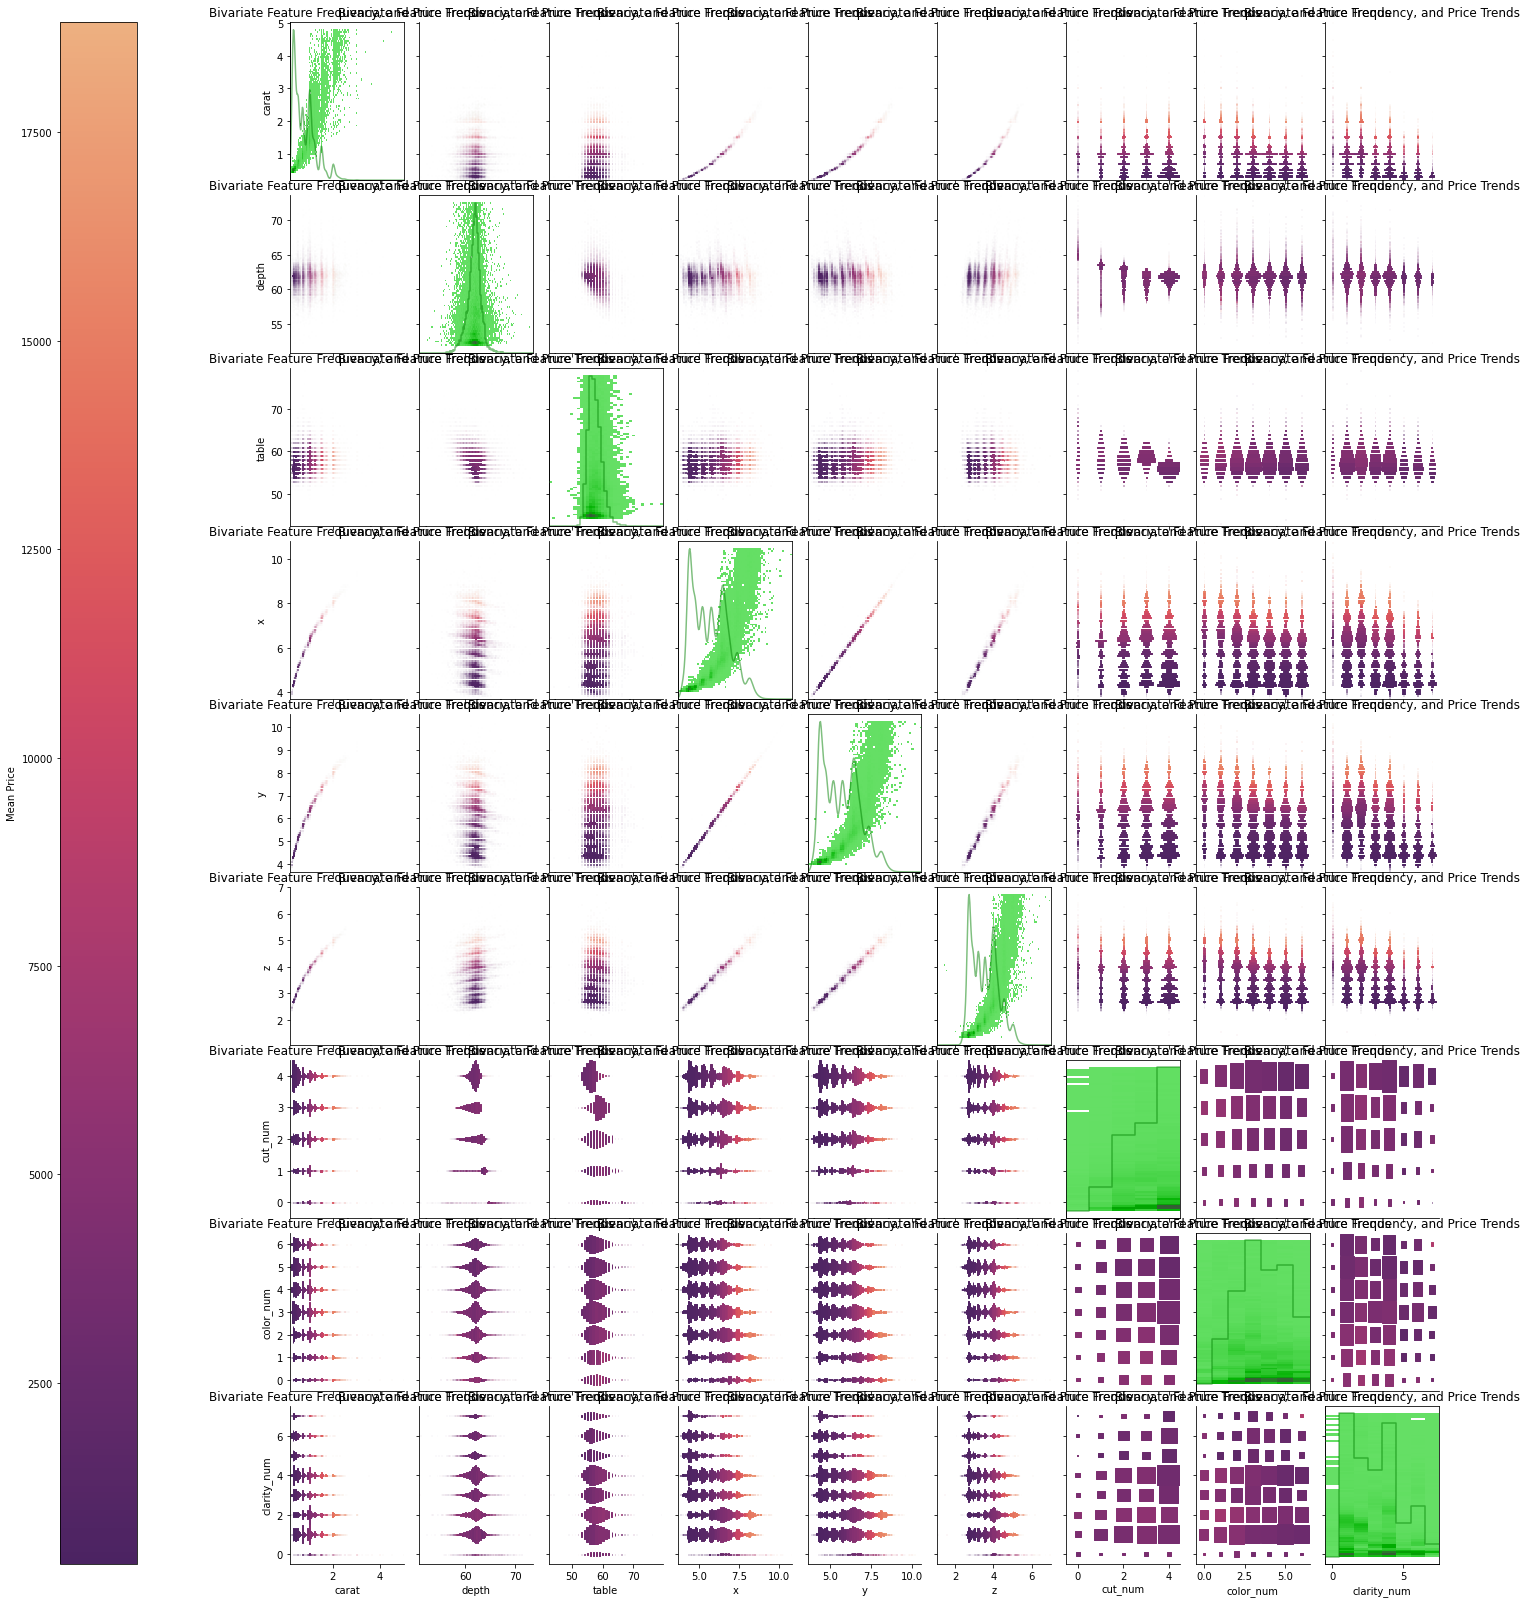

In [26]:
if enable_visualizations:
    n = sns.PairGrid(diamonds_k_numeric, vars=diamonds_k_numeric.drop("price", axis=1).columns)
    n.set(title="Bivariate Feature Frequency, and Price Trends")
    n.map_diag(potentially_categoric_histplot, y=diamonds_k_numeric["price"], color="green")
    n.map_offdiag(pairgrid_heatmap, sm=sm)
    plt.colorbar(sm, ax=n.axes, location='left', label="Mean Price")
    pairgrid_figure = n

This visualization was critical in determining if any features needed modification before being presented to the model. Because all the relationships were either weakly correlated or roughly monotonic, this visualization supported the decision not to do any additional feature engineering before fitting the model, as each feature met the criteria for being linearly seperable.
  
    
**About the visualization**  
This visualization is a combination of several different plot types, designed to enable rapid investigation of nonlinearities and correlations. The off-diagonal plots are extensions of histograms, where the mark size and opacity together indicate frequency, and the color maps to price. The on-diagonal plots compare their intersecting features with price, taking the form of a bivariate histogram (the spray of green, where darkness indicates frequency) and a univariate histogram (the line plot, where height indicates density across the X axis).
  
  

## Fitting the Model

In [27]:
from sklearn.tree import DecisionTreeRegressor

In [28]:
diamonds_k_train = diamonds_k_numeric.sample(frac=0.8)
diamonds_k_test = diamonds_k_numeric.drop(diamonds_k_train.index)

diamonds_k_train_x = diamonds_k_train.drop("price", axis=1);
diamonds_k_train_y = diamonds_k_train["price"];

diamonds_k_test_x = diamonds_k_test.drop("price", axis=1);
diamonds_k_test_y = diamonds_k_test["price"];

In [29]:
selected_model = DecisionTreeRegressor # 96% accurate
# selected_model = sklearn.linear_model.LinearRegression # 89% accurate
# selected_model = sklearn.linear_model.BayesianRidge      # 89% accurate
# selected_model = MLPRegressor # 96% accurate

In [30]:
price_model = selected_model().fit(diamonds_k_train_x, diamonds_k_train_y)

$\pagebreak$

# Knowledge to Wisdom

## Model Evaluation

### Accuracy Analysis

In [31]:
model_validation_accuracy = price_model.score(diamonds_k_test_x, diamonds_k_test_y)
print(model_validation_accuracy)

0.9660741312213303


The model has a demonstrated accuracy of 96.8% on validation data. This datum is a representative artifact of the model's generality, demonstrating that as new diamonds are put on the market, this model will remain able to generate accurate prices for them.

### Throughput and Latency Analysis

#### Profiling and Constructing Visualizations

##### Hyperparameters

In [32]:
min_throughput=50000
max_latency = 0.05
h_confidence=0.999
l_confidence = 1.0-h_confidence

In [33]:
max_batch_e10 = 7
samples_per_e10= 10
num_samples = max_batch_e10*samples_per_e10
batch_sizes = np.logspace(1, max_batch_e10, num=num_samples).astype(np.int64)
n_runs_per_size = 100

##### Setting up Profiling

In [34]:
import timeit, os
from multiprocessing import Pool
from scipy.ndimage.filters import gaussian_filter1d

In [35]:
def _preparePredictionArgs(**kwargs):
    prepped_values = pd.DataFrame(columns=diamonds_w_x.drop(["clarity", "color", "cut"], axis=1).columns)
    for key, value in kwargs.items():
        if key in diamonds_w_x_cat.columns:
            categories = diamonds_w_x_cat[key].cat.categories
            prepped_values[key + "_num"] = [categories.get_loc(value) / (len(categories)-1)]
        else:
            prepped_values[key] = [value]
    return prepped_values

def _predictOnPreppedArgs(prepped_values):
    return price_model.predict(prepped_values)

In [36]:
def predictPrice(**kwargs):
    return _predictOnPreppedArgs(_preparePredictionArgs(**kwargs))

In [37]:
randDiamonds = lambda n_diamonds: pd.DataFrame(np.random.rand(n_diamonds, len(diamonds_k_numeric.columns)-1), columns=diamonds_k_numeric.drop("price", axis=1).columns)

In [38]:
def time_for_n_diamonds(n_diamonds):
    diamonds = randDiamonds(n_diamonds)
    start = timeit.default_timer()
    price_model.predict(diamonds)
    return timeit.default_timer() - start

def batch_time_for_n_diamonds(n_diamonds):
    return [(n_diamonds, time_for_n_diamonds(n_diamonds)) for _ in range(n_runs_per_size)]

##### Executing profiling

In [39]:
import pickle
# Distribute the testing across the CPU
if run_performance_tests:
    with Pool() as p:
        p.map(batch_time_for_n_diamonds, [1000]*10) # Warmup to stabilize timing
        times = pd.DataFrame.from_records([time_pair for time_pair_list in p.map(batch_time_for_n_diamonds, batch_sizes) for time_pair in time_pair_list], columns=["batch_size", "s/batch"])
    with open(r"./times.pickle", 'wb+') as f:
        pickle.dump(times, f);
else:
    try:
        with open(r"./times.pickle", "rb") as f: times = pickle.load(f)
    except FileNotFoundError:
        print("A file (times.pickle) is missing. If you feel you have followed the user's guide, contact Zach Allen.")
        raise

##### Preparing Profiling Data Visualization

In [40]:
times["q/s"] = times["batch_size"] / times["s/batch"]

In [41]:
# Compute the confident boundary for the two metrics we care about
quantiles = times.groupby("batch_size")\
                .agg({"q/s": lambda x: x.quantile(l_confidence), "s/batch": lambda x: x.quantile(h_confidence)})\
                .reset_index()\
                .apply(lambda x: gaussian_filter1d(x, sigma=1))

# Pre-compute for what batch sizes we are confident we meet KPIs.
quantiles["q/s_is_valid"] = quantiles["q/s"] > min_throughput
quantiles["s/batch_is_valid"] = quantiles["s/batch"] < max_latency
quantiles["batch_size_is_valid"] = np.logical_and(quantiles["q/s_is_valid"], quantiles["s/batch_is_valid"])

In [42]:
bounds_hatches = {
    "upper": "\\\\\\",
    "lower": "///"
}
bounds_percentiles = {
    "upper": "99.9",
    "lower": "0.1"
}

In [43]:
def fill_between_valid(ax, key, color, bound_type:str, ymin=None, ymax=None, times=times, quantiles=quantiles, alpha=0.1, **kwargs):
    return ax.fill_between(
        "batch_size", 
        times[key].min() if ymin is None else ymin,
        times[key].max() if ymax is None else ymax,
        where=key+"_is_valid", 
        color=color, 
        alpha=alpha, 
        hatch=bounds_hatches[bound_type],
        data=quantiles,
        **kwargs)

In [44]:
def plot_acceptable_range(ax, key, title, units, color, boundary, bound_type, quantiles=quantiles, **kwargs):
    ax.axhline(y=boundary, color=f"dark{color}", linestyle="-.", label=f"{units} KPI")
    return fill_between_valid(ax, key, color, bound_type, **kwargs)

In [45]:
def style_performance_histogram(ax, color):
    ax.tick_params(axis='y', colors=color)
    ax.yaxis.label.set_color(color)

In [46]:
def plot_performance_histogram(ax, key, title, units, color, boundary, bound_type, num_samples=num_samples, times=times, quantiles=quantiles, **kwargs):
    hist = sns.histplot(times, x="batch_size", y=key, color=color, bins=num_samples, log_scale=True, ax=ax)
    quan = ax.plot("batch_size", key, "--", color=f"dark{color}", label=f"{units} {bounds_percentiles[bound_type]}%ile", data=quantiles)
    ax.yaxis.label.set_text(f"{title} ({units})")
    ax.set_ylim([times[key].min(), times[key].max()])
    return hist, quan

In [47]:
def performance_histogram(ax, key, title, units, color, boundary, bound_type, intersection_ax = None, **kwargs):
    plot_performance_histogram(ax, key, title, units, color, boundary, bound_type, **kwargs)
    plot_acceptable_range(ax, key, title, units, color, boundary, bound_type, **kwargs)
    style_performance_histogram(ax, color)

    if intersection_ax is not None:
        fill_between_valid(intersection_ax, key, color, bound_type, ymin=0, ymax=1)

In [48]:
# Compute the boundaries of our acceptable region
batch_size_becomes_valid = (quantiles["batch_size_is_valid"]>quantiles["batch_size_is_valid"].shift(1))
batch_size_exits_valid   = (quantiles["batch_size_is_valid"]>quantiles["batch_size_is_valid"].shift(-1))
x_ticks = quantiles.loc[batch_size_becomes_valid + batch_size_exits_valid, "batch_size"]

# Convert those boundaries into scientific notation for labeling purposes
x_tick_labels = [np.format_float_scientific(d, precision=0) for d in x_ticks]

In [49]:
# Set up the multiple subplots
hspace=0
fig, axes = plt.subplots(3, figsize=(8, 4.5), gridspec_kw={'height_ratios': [1, 0.2, 1], "hspace": hspace})
fig.suptitle=("Throughput and Latency vs. Batch Size")
plt.xlabel("Queries/Batch")
fig.tight_layout()
qs_ax, in_ax, sb_ax = axes

# Plot the main histograms, along with sending data to the intersection axis
performance_histogram(qs_ax, "q/s",  "Throughput", "Queries/s", "green", 50000, "lower", intersection_ax=in_ax)
performance_histogram(sb_ax, "s/batch", "Latency", "s/Batch",   "blue",  0.05,  "upper", intersection_ax=in_ax)

# sharex prevents different ticks for different plots, so we're emulating sharex
xlim = [quantiles["batch_size"].min(), quantiles["batch_size"].max()]
for ax in axes: 
    ax.set_xlim(xlim)
    ax.set_xscale("log")

# Plot custom tick marks on the upper axis, denoting boundaries of reliability
qs_ax.xaxis.set_tick_params(labelbottom=True)
qs_ax.axes.set_xticks(x_ticks)
qs_ax.axes.set_xticklabels(x_tick_labels)

# Hide the border and labeling of the intersection axis
in_ax.axis("off")

fig.legend(loc=[.7, .64])
plt.close()
performance_graph = fig

#### Profiling Visualization

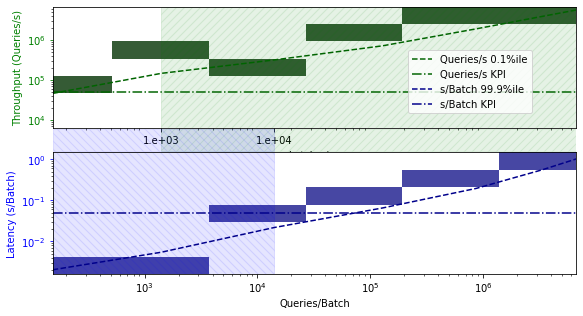

In [50]:
display(performance_graph)

This visualization shows that there are a wide range of batch sizes which meet the KPIs: any batch size between 800 and 300,000 give suitable throughput and latency.  

This visualization supports the decision to continue to phase 2, since there is considerable performance headroom as demonstrated by the 3 orders of magnitude over which the batch size could vary and remain within the expected range.

### Hypothesis Verification
The model's KPIs were an accuracy of >95%, a throughput of >5000 queries/second, and a latency of &lt;50ms/query. The model met each of these KPIs by a significant margin. That definitively demonstrates that a model was made which met the KPIs given.

## Interactive Model

#### Setting up Interactivity

In [51]:
from ipywidgets import FloatSlider, SelectionSlider, interactive_output, VBox
from IPython.display import display

In [52]:
maxFloatSlider = lambda max, name: FloatSlider(min=0, max=max, step=0.1, value=0.0, description=name, continuous_update=False)
ordCatagSlider = lambda opt, name: SelectionSlider(options=opt, description=name, continuous_update=False)

In [53]:
diamonds_w_x = diamonds_k.drop("price", axis=1)
diamonds_w_x_num = diamonds_w_x.select_dtypes(include="number")
diamonds_w_x_cat = diamonds_w_x.select_dtypes(include="category")

In [54]:
num_sliders = {key: maxFloatSlider(np.ceil(col.max()/5.0)*5.0, key) for key, col in diamonds_w_x_num.iteritems() if key[-4:] != "_num"}
cat_sliders = {key: ordCatagSlider(col.cat.categories, key) for key, col in diamonds_w_x_cat.iteritems()}

In [55]:
def displayPredictedPrice(**kwargs):
    prediction = predictPrice(**kwargs)
    print(f"That should be about ${prediction[0]:0,.2f}")

#### Interactive Price Prediction

In [56]:
model_interactive_output = interactive_output(displayPredictedPrice, {**num_sliders, **cat_sliders})
model_interactive = VBox([s for c, s in 
              sorted([
                        (correlation_with_price[key], slider) 
                            if key in correlation_with_price 
                            else (correlation_with_price[key+"_num"], slider) 
                        for key, slider in 
                            [*num_sliders.items(), *cat_sliders.items()]
                    ], 
                    reverse=True)
              ] + [model_interactive_output]
        )
display(model_interactive) # NOTE: This will not render correctly to a PDF, but functions in the actual notebook.

## Conclusions and Recommendations

A model has been demonstrated with high accuracy and high efficiency. The model meets established KPIs. Based on this, the model should be utilized in Phase 2 of the 'In The Loupe' project.

# Appendix

## Application Testing - Report Communication and Clarity
The direct customer for this phase of 'In The Loupe' are FBay's stakeholders, deciding whether to continue to Phase 2 or not. That means the key performance indicator of Phase 1 is the ease with which its products (this report) can be understood. I applied software testing strategies to ensure this document communicates clearly.

#### Unit Testing
- [x] Are variable names and section headings in their final form?
- [x] Are all debugging commands removed?
- [x] Does every figure have a Title, Axis, Intervals, Labels, and Scale?
- [ ] Are there versioning disputes, old measurements, or other out-of-date aspects?
    - [ ] Final Performance Evaluation
- [ ] Is the datafile path up-to-date?
    - [ ] Even after transitioning to evaluation hosting?
- [x] Are there cells which should be joined?

#### Integration Testing
- [ ] Do all links function correctly?
    - [ ] In the Jupyter Notebook?
    - [ ] In the exported PDF?
- [x] Is terminology consistent?
    - [x] Project KPIs vs requirements vs goals
    - [x] variable vs feature vs characteristic

#### System Testing
- [ ] Can the notebook be executed interactively for evaluation?
    - [ ] Are there clear instructions for starting that hosting?

## Figures

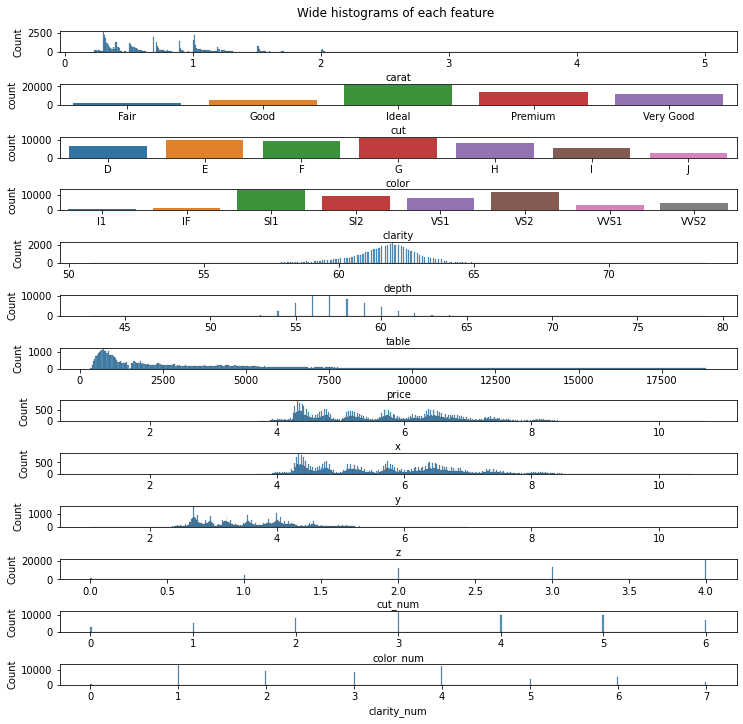

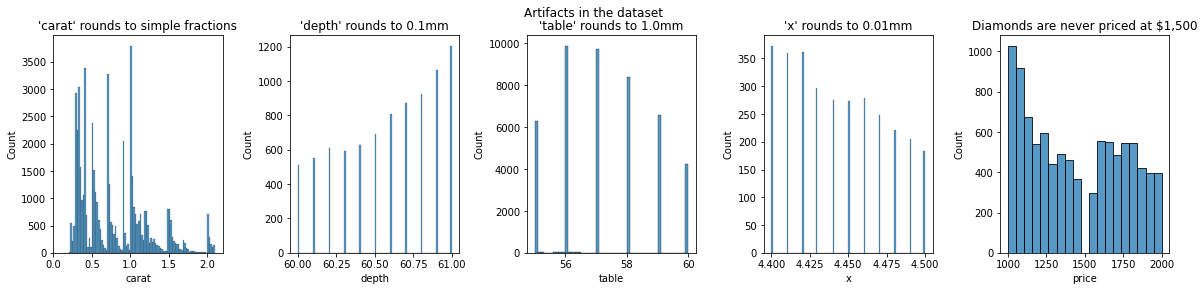

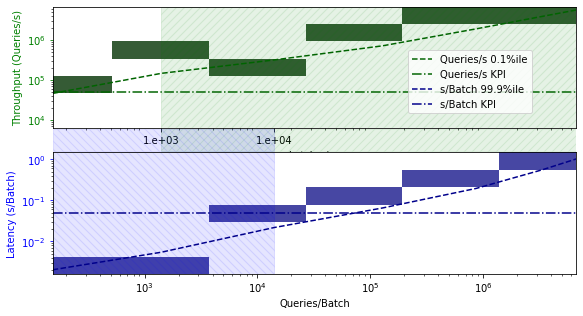

In [57]:
display(univariate_analysis_figure)
display(artifacts_fig)
display(pairgrid_figure)
display(performance_graph)

## Summation of Learning Experience
I have several years of industry experience in designing large-scale data pipelines and machine learning tools. However, because most of that experience was on a jobsite, I've felt a small but growing desire to stretch my legs and try some new tools, to practice being a life-long learner. As a result, my approach to this project was much more exploring new skills than exploiting existing knowledge.  

Specifically, this capstone project gave me a wonderful opportunity to familiarize myself with the `pandas` and `seaborn` python packages, which are designed to provide more user-friendly features and metadata management than `numpy` and `matplotlib`. Luckily, `pandas`, `seaborn`, and most other software tools are well documented on the web, so I didn't need to reach out to any other people for learning help or any other assistance.

This experience has reminded me that new tools are not always better, but they're usually different. For example, `seaborn` is better than `matplotlib` at assuming what you want, but worse at helping you fix its mistakes.

## WGU Evaluator's Guide
The structure of this document emerged from the actual process of developing the software, and has been merged with the requirements placed by WGU evaluation. To best support WGU Evaluators, I've mapped C964 requirements to document sections.

[Report Summary](#Summary)

### C964.C - Data Product
- [x] Data Methods
	- [x] Descriptive
		- [Univariate Analysis](#Univariate-Analysis) 
		- [Artifact Investigations](#Artifact-Investigations)
		- [Feature Correlations with Price](#Feature-Correlations-with-Price)
		- [Displaying Bivariate Distributions](#Displaying-Bivariate-Distributions)
		- [Figures](#Figures)
	- [x] Predictive
		- [Fitting the Model](#Fitting-the-Model)
- [x] Datasets
	- [Dataset Selection](#Dataset-Selection)
- [x] Data Cleaning
	- [Data Pipeline](#Data Pipeline)
- [x] Data Visualization
    - [Univariate Analysis](#Univariate-Analysis) 
    - [Artifact Investigations](#Artifact-Investigations)
    - [Displaying Bivariate Distributions](#Displaying-Bivariate-Distributions)
    - [Profiling Visualization](#Profiling-Visualization)
    - [Figures](#Figures)
- [x] Real-Time Queries
	- [Interactive Price Prediction](#Interactive-Price-Prediction)
- [x] Outcome Accuracy
	- [Accuracy Analysis](#Accuracy-Analysis) 
- [x] Product Health Monitoring
	- [Log errors to a file](#Configuring-logging)
- [x] Dashboard
	- [Interactive Price Prediction](#Interactive-Price-Prediction)
	- [Univariate Analysis](#Univariate-Analysis) 
	- [Artifact Investigations](#Artifact-Investigations)
	- [Displaying Bivariate Distributions](#Displaying-Bivariate-Distributions)
	- [Profiling Visualization](#Profiling-Visualization)

### C964.D - Product Documentation
- [x] [Project Purpose](#Project-Purpose)
- [x] Datasets
	- [Dataset Selection](#Dataset-Selection)
- [x] Data Product Code
    - This notebook is the entire code for the data product.
- [x] [Hypothesis Verification](#Hypothesis-Verification)
	- [Conclusions and Recommendations](#Conclusions-and-Recommendations)
- [x] Effective Visualizations and Reporting
	- [Univariate Analysis](#Univariate-Analysis)
	- [Artifact Investigations](#Artifact-Investigations)
	- [Displaying Bivariate Distributions](#Displaying-Bivariate-Distributions)
	- [Profiling Visualization](#Profiling-Visualization)
	- [Figures](#Figures)
- [x] [Accuracy Analysis](#Accuracy-Analysis) 
	- [Conclusions and Recommendations](#Conclusions-and-Recommendations)
- [x] Application Testing
	- [Application Testing - Data Pipeline](#Application-Testing---Data-Pipeline)
	- [Application Testing - Report Communication and Clarity](#Application-Testing---Report-Communication-and-Clarity)
    - [Artifact Investigations](#Artifact-Investigations)
- [x] Application Files
    - All the files of this submission can be accessed at [my personal GitHub repo for C968](https://github.com/FractalMachinist/WGU-C968)
- [x] [User's Guide](#Users-Guide)
- [x] [Summation of Learning Experience](#Summation-of-Learning-Experience)

### C964.E - Academic Integrity
This report does not draw on any sources in any manner which require citation. Some sources are linked, but their content is not presented, summarized, or evaluated in this document.

## Document Export

In [58]:
%%capture
!jupyter nbconvert --TemplateExporter.extra_template_basedirs="/srv/conda/envs/notebook/share/jupyter/nbconvert/templates/" --template=latex --template-file=./better_report.tplx --to PDF "./In The Loupe Phase 1 Report.ipynb"